In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and prepare the customer profiles
customers = pd.read_csv("C:\E\data_analytics\Customers.csv")
products = pd.read_csv("C:\E\data_analytics\Products.csv")
transactions = pd.read_csv("C:\E\data_analytics\Transactions.csv")

In [3]:
# Merge datasets to create enriched customer profiles
transactions = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='left')
customer_profiles = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Category': lambda x: x.value_counts().index[0]  # Most frequent category
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Category': 'PreferredCategory'
}).reset_index()

customer_profiles = customer_profiles.merge(customers, on='CustomerID', how='left')

In [4]:
# Encode categorical features (Region, PreferredCategory)
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region', 'PreferredCategory'], drop_first=True)

In [5]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['TotalSpending', 'TransactionCount']
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

In [6]:
# Select features for clustering
if 'SignupYear' in customer_profiles.columns:
    features = customer_profiles.drop(columns=['CustomerID', 'CustomerName', 'SignupDate', 'SignupYear'])
else:
    # If 'SignupYear' is not found, drop only the other columns
    features = customer_profiles.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

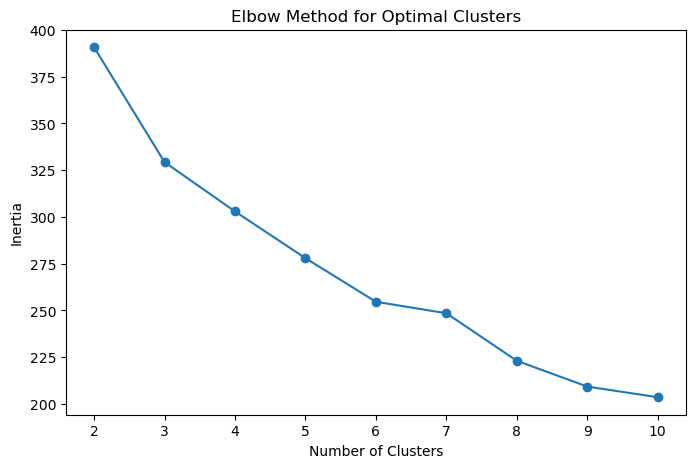

In [7]:
# Determine the optimal number of clusters using Elbow Method
inertia = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [8]:
# Apply KMeans with the chosen number of clusters (e.g., 4)
optimal_clusters = 4  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(features)

C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [9]:
# Evaluate clustering performance using Davies-Bouldin Index
db_index = davies_bouldin_score(features, customer_profiles['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.8496564881692539


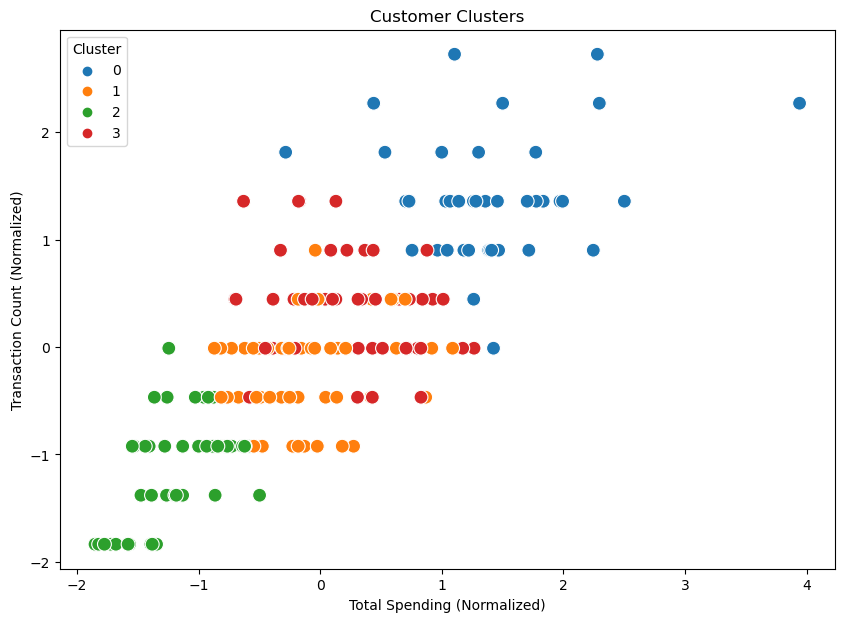

In [10]:
# Visualize clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=customer_profiles['TotalSpending'],
    y=customer_profiles['TransactionCount'],
    hue=customer_profiles['Cluster'],
    palette='tab10',
    s=100
)
plt.title('Customer Clusters')
plt.xlabel('Total Spending (Normalized)')
plt.ylabel('Transaction Count (Normalized)')
plt.legend(title='Cluster')
plt.show()

In [11]:
# Save cluster results
customer_profiles[['CustomerID', 'Cluster']].to_csv('Customer_Segments.csv', index=False)
print("Customer segmentation completed! Results saved to Customer_Segments.csv.")

Customer segmentation completed! Results saved to Customer_Segments.csv.
